In [55]:
import geopandas
import geopandas as gpd
import pandas as pd
from osgeo import ogr,gdal
import numpy 
from shapely.wkb import loads
from shapely.geometry import Point
from shapely.geometry import LineString
import matplotlib.pyplot as plt
import openpyxl
import itertools
import networkx as nx
from simplify import *

import warnings
warnings.filterwarnings("ignore")

In [56]:
gdal.SetConfigOption("OSM_CONFIG_FILE", "osmconf.ini")

# Define a helper function to generate pairs of consecutive elements in a list
def pairwise(iterable):
    "s -> (s0, s1), (s1, s2), (s2, s3), ..."
    a, b = itertools.tee(iterable)
    next(b, None)
    return zip(a, b)
    
# Define a helper function to generate permutations
def permutations(iterable, r=None):
   # permutations('ABCD', 2) --> AB AC AD BA BC BD CA CB CD DA DB DC
    # permutations(range(3)) --> 012 021 102 120 201 210
    pool = tuple(iterable)
    n = len(pool)
    r = n if r is None else r
    if r > n:
        return
    indices = list(range(n))
    cycles = list(range(n, n-r, -1))
    yield tuple(pool[i] for i in indices[:r])
    while n:
        for i in reversed(range(r)):
            cycles[i] -= 1
            if cycles[i] == 0:
                indices[i:] = indices[i+1:] + indices[i:i+1]
                cycles[i] = n - i
            else:
                j = cycles[i]
                indices[i], indices[-j] = indices[-j], indices[i]
                yield tuple(pool[i] for i in indices[:r])
                break
        else:
            return 
        
# Retrive data from OSM and get the geographic data of tram
def query_b(geoType,keyCol,**valConstraint):
    """
    This function builds an SQL query from the values passed to the retrieve() function.
    Arguments:
         *geoType* : Type of geometry (osm layer) to search for.
         *keyCol* : A list of keys/columns that should be selected from the layer.
         ***valConstraint* : A dictionary of constraints for the values. e.g. WHERE 'value'>20 or 'value'='constraint'
    Returns:
        *string: : a SQL query string.
    """
    query = "SELECT " + "osm_id"
    for a in keyCol: query+= ","+ a  
    query += " FROM " + geoType + " WHERE "
    # If there are values in the dictionary, add constraint clauses
    if valConstraint: 
        for a in [*valConstraint]:
            # For each value of the key, add the constraint
            for b in valConstraint[a]: query += a + b
        query+= " AND "
    # Always ensures the first key/col provided is not Null.
    query+= ""+str(keyCol[0]) +" IS NOT NULL" 
    return query 

def retrieve(osm_path,geoType,keyCol,**valConstraint):
    """
    Function to extract specified geometry and keys/values from OpenStreetMap
    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region 
        for which we want to do the analysis.     
        *geoType* : Type of Geometry to retrieve. e.g. lines, multipolygons, etc.
        *keyCol* : These keys will be returned as columns in the dataframe.
        ***valConstraint: A dictionary specifiying the value constraints.  
        A key can have multiple values (as a list) for more than one constraint for key/value.  
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with all columns, geometries, and constraints specified.    
    """
    driver=ogr.GetDriverByName('OSM')
    data = driver.Open(osm_path)
    query = query_b(geoType,keyCol,**valConstraint)
    sql_lyr = data.ExecuteSQL(query)
    features =[]
    # cl = columns 
    cl = ['osm_id']
    
    
    for a in keyCol: cl.append(a)
    if data is not None:
        for feature in sql_lyr:
            try:
                if feature.GetField(keyCol[0]) is not None:
                    shapely_geo = shapely.from_wkt(feature.geometry().ExportToWkt())
                    if shapely_geo is None:
                        continue
                    # field will become a row in the dataframe.
                    field = []
                    for i in cl: field.append(feature.GetField(i))
                    field.append(shapely_geo)   
                    features.append(field)
            except:
                print("WARNING: skipped OSM feature")
      
    cl.append('geometry')                   
    if len(features) > 0:
        return geopandas.GeoDataFrame(features,columns=cl) #,crs={'init': 'epsg:4326'}
    else:
        print("WARNING: No features or No Memory. returning empty GeoDataFrame") 
        return geopandas.GeoDataFrame(columns=['osm_id','geometry']) #,crs={'init': 'epsg:4326'}    
    
def road(osm_path):
    
    return retrieve(osm_path,'lines',['highway'],**{'highway':["='tertiary'"]})  


def mainRoads(osm_path):
    """
    Function to extract main road linestrings from OpenStreetMap  

    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region 
        for which we want to do the analysis.        
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with all unique main road linestrings.   
    """ 
    return retrieve(osm_path,'lines',['highway','oneway','lanes','maxspeed'],**{'highway':["='primary' or ","='trunk' or ","='motorway' or ","='trunk_link' or ",
                    "='primary_link' or ", "='secondary' or ","='tertiary' or ","='tertiary_link'"]})

    
# def bus_network(osm_path):

#     df_road = road(osm_path)
    
#     # bus = df_road.loc[df_road.railway == '']
    
#     return bus

def public_stations(osm_path):

    
    return (retrieve(osm_path,'points',['public_transport', 'tram', 'subway', 'bus', 'name']))

def stations_bus(osm_path):
    df_publich__transport_stations = public_stations(osm_path)
    
    stations_bus = df_publich__transport_stations.loc[df_publich__transport_stations.bus == 'yes']
    stations_bus = stations_bus.loc[stations_bus.public_transport == 'platform']
    
    stations_bus['geo_x'] = stations_bus.geometry.x
    stations_bus['geo_y'] = stations_bus.geometry.y
    
    return stations_bus

def add_stations(net,station_file):
    
    station_geometries = pd.DataFrame(station_file.geometry)
    
    net.nodes = pd.concat([net.nodes,station_geometries]).reset_index(drop=True)
                           
    return net

# Pre-processing the geographic data of the subway network to obtain 'edges' and 'nodes'
def prepare_network(subway,station_file):
    """
    Prepare a subway network represented as a GeoDataFrame of LineString objects for routing.

    Args:
    - subway: a GeoDataFrame representing the subway network, with 'geometry' column containing LineString objects
    
    Returns:
    - a tuple of two DataFrames representing the edges and nodes of the prepared network

    Example:
    >>> import geopandas
    >>> subway = geopandas.read_file('subway.shp')
    >>> edges, nodes = prepare_network(subway)

    Note: This function requires the shapely, NetworkX, and Pandas libraries to be installed.
    """

    # Build a Network object from the subway edges
    net = Network(edges=subway)

    # Add endpoints to the network where edges don't intersect
    net = add_endpoints(net)
    
    # Add endpoints to the network where edges don't intersect
    net = add_stations(net,station_file)
        
    # Split edges at new endpoints
    net = split_edges_at_nodes(net)

    # Add new endpoints where edges were split
    net = add_endpoints(net)

    # Assign unique IDs to nodes and edges
    net = add_ids(net)

    # Add missing topology information to the network's edges
    net = add_topology(net)    

    # Calculate the degree of each node in the network
    net.nodes['degree'] = calculate_degree(net)

    # Merge edges with a degree of 2
    #net = merge_edges(net)

    # Drop duplicate edges
    net.edges = drop_duplicate_geometries(net.edges, keep='first') 

    # Reset node and edge IDs after fixing topology and merging edges
    net = reset_ids(net) 

    # Add edge distances
    net = add_distances(net)

    # Merge any MultiLineString edges
    net = merge_multilinestrings(net)

    # Add travel time for each edge based on distance and average speed
    net = add_travel_time(net)
    
    # Return the edges and nodes of the prepared network
    return net.edges, net.nodes

def expand_edges(edges):
    """
    Expand a DataFrame of edges into a format that can be used with network analysis algorithms.

    Args:
    - edges: a DataFrame containing edges with columns 'from_id', 'to_id', and 'distance'

    Returns:
    - a DataFrame containing expanded edges with columns 'from_id', 'to_id', 'distance', 'weights', 'to_from', and 'from_to'

    Example:
    >>> edges = pd.DataFrame({'from_id': [0, 0, 1], 'to_id': [1, 2, 2], 'distance': [1.5, 3.2, 2.8]})
    >>> expand_edges(edges)
      from_id  to_id  distance  weights  to_from  from_to
    0       0      1       1.5        1  (0, 1)  (1, 0)
    1       0      2       3.2        3  (0, 2)  (2, 0)
    2       1      2       2.8        2  (1, 2)  (2, 1)

    Notes:
    - The 'weights' column is created by rounding the 'distance' column to the nearest integer.
    - The 'to_from' and 'from_to' columns are created to facilitate conversion between edge formats.
    """
    # Round the distance to the nearest integer and store it in a new column 'weights'
    edges['weights'] = edges['distance'].astype(int)

    # Create 'to_from' and 'from_to' columns to facilitate conversion between edge formats
    edges['to_from'] = list(zip(edges.from_id, edges.to_id))
    edges['from_to'] = list(zip(edges.to_id, edges.from_id))

    # Return the expanded edges DataFrame
    return edges

## Step1: retrive all tram stations, edges and nodes from OSM map

In [57]:
#osm_path = "C:\\projects\\UTNCE\\data\\Amsterdam.osm.pbf"
osm_path = "C:\\projects\\UTNCE\\data\\Amsterdam.bbbike.pbf"

In [58]:
am_roads = road(osm_path)

<Axes: >

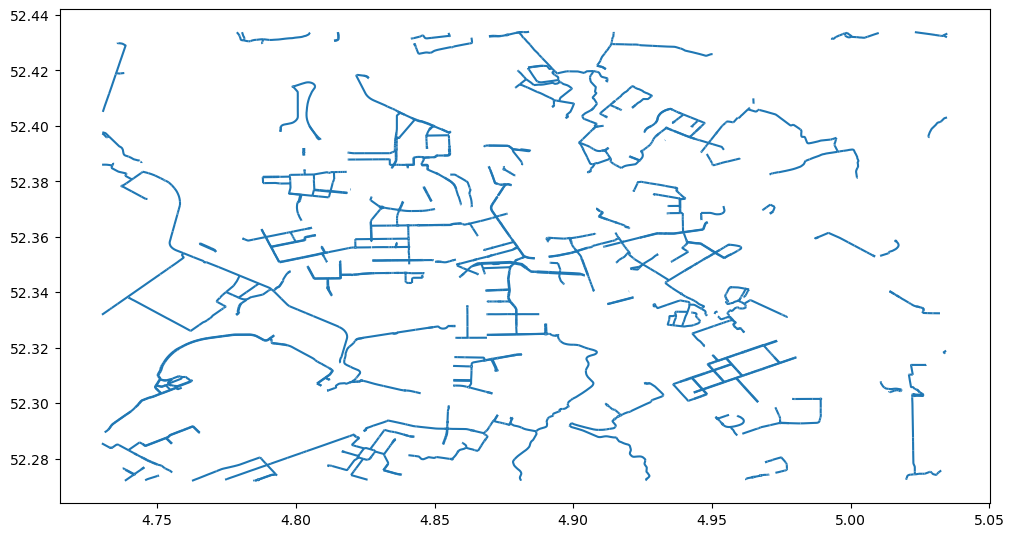

In [59]:
fig, ax = plt.subplots(1, 1,figsize=(12,10))

gpd.GeoDataFrame(am_roads.copy()).plot(ax=ax,zorder=0)

In [60]:
am_main_roads = mainRoads(osm_path)

TypeError: 'NoneType' object is not iterable

In [61]:
am_main_roads

NameError: name 'am_main_roads' is not defined

In [ ]:
fig, ax = plt.subplots(1, 1,figsize=(12,10))

gpd.GeoDataFrame(am_roads.copy()).plot(ax=ax,zorder=0)

In [52]:
am_bus_stations = stations_bus(osm_path)

In [53]:
am_bus_stations

,osm_id,public_transport,tram,subway,bus,name,geometry,geo_x,geo_y
5,45989456,platform,None,None,yes,Nesserlaan,POINT (4.83890 52.27701),4.838900,52.277010
174,290955154,platform,None,None,yes,Badhoevelaan,POINT (4.79002 52.34049),4.790015,52.340489
226,311831619,platform,None,None,yes,Oostzanerdijk,POINT (4.88103 52.42043),4.881026,52.420431
227,311831882,platform,None,None,yes,Oostzanerdijk,POINT (4.88145 52.42022),4.881446,52.420219
231,318147070,platform,None,None,yes,Kometensingel,POINT (4.88289 52.41662),4.882885,52.416617
...,...,...,...,...,...,...,...,...,...
3658,10275543481,platform,None,None,yes,Centrum,POINT (4.77954 52.33798),4.779539,52.337981
3659,10275543482,platform,None,None,yes,Centrum,POINT (4.77918 52.33790),4.779176,52.337904
3668,10581455633,platform,None,None,yes,Station Diemen,POINT (4.96661 52.34414),4.966605,52.344137
3673,10778465608,platform,None,None,yes,Hogeschool InHolland,POINT (4.95989 52.32689),4.959887,52.326889


In [46]:
am_bus_stations

,osm_id,public_transport,tram,subway,bus,name,geometry,geo_x,geo_y
1,45979527,stop_position,None,None,yes,Westwijk,POINT (4.83009 52.27420),4.830088,52.274203
2,45979744,stop_position,None,None,yes,Sluis,POINT (5.02391 52.27442),5.023914,52.274421
3,45980296,stop_position,None,None,yes,Sluis,POINT (5.02437 52.27450),5.024366,52.274499
4,45984876,stop_position,None,None,yes,"Aalsmeer, Nieuw Oosteinde",POINT (4.80938 52.27574),4.809385,52.275743
6,45991272,stop_position,None,None,yes,"Aalsmeer, Machineweg",POINT (4.78909 52.27753),4.789086,52.277532
...,...,...,...,...,...,...,...,...,...
3664,10573390383,stop_position,None,None,yes,Archangelkade,POINT (4.87193 52.39554),4.871933,52.395537
3666,10573464339,stop_position,None,None,yes,Archangelkade,POINT (4.87199 52.39539),4.871988,52.395390
3669,10582633274,stop_position,None,None,yes,Olof Palmeplein,POINT (4.94008 52.39669),4.940081,52.396687
3671,10661819286,stop_position,None,None,yes,Wolbrantskerkweg,POINT (4.79742 52.35691),4.797423,52.356906


<Axes: >

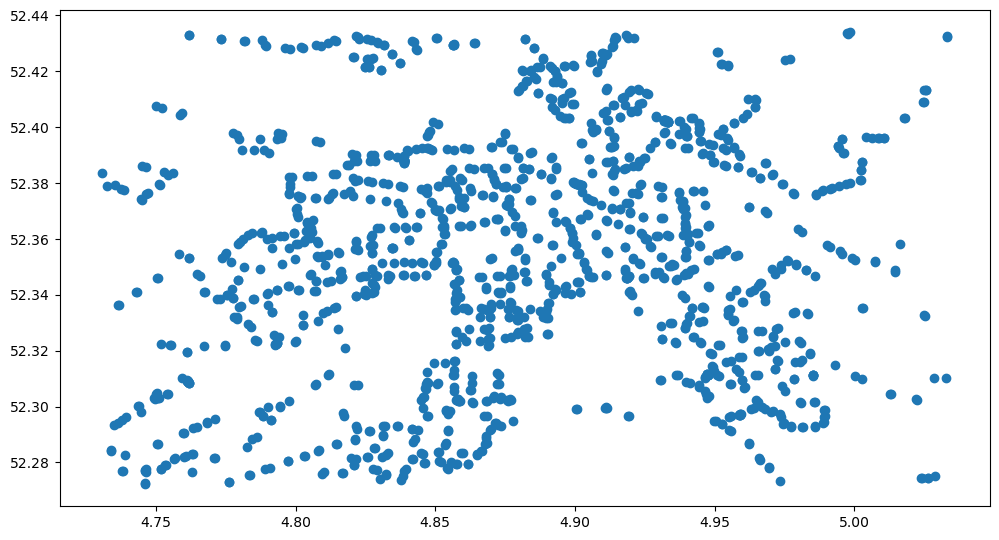

In [9]:
fig, ax = plt.subplots(1, 1,figsize=(12,10))

gpd.GeoDataFrame(am_bus_stations.copy()).plot(ax=ax,zorder=0)

In [ ]:
am_all_tram_stations = tram_stations(osm_path)

In [ ]:
am_all_tram_stations.to_excel('./am_all_tram_stations.xlsx',header = True, index = False)  

In [ ]:
gpd.GeoDataFrame(am_all_tram_stations.copy()).to_file('am_all_tram_stations.GPKG',driver='GPKG')

In [ ]:
tram = tram_network(osm_path)

In [ ]:
edges,nodes = prepare_network(tram,am_all_tram_stations)

In [ ]:
edges = expand_edges(edges)

In [ ]:
gpd.GeoDataFrame(edges[['geometry','id','from_id','to_id']].copy()).to_file('edges_tram_amsterdam.GPKG',driver='GPKG')

In [ ]:
gpd.GeoDataFrame(nodes[['geometry','id']].copy()).to_file('nodes_tram_amsterdam.GPKG',driver='GPKG')

In [ ]:
am_tram_routes = tram_routes(osm_path)

In [ ]:
am_tram_routes = am_tram_routes.loc[am_tram_routes.ref != 'EMA']

In [ ]:
am_tram_routes = sorted_routes(am_tram_routes)

In [ ]:
# am_tram_routes

Need to check if the name of real start station is the same to the 'to' column

In [ ]:
need_revised_row = check_to_column(am_tram_routes, am_all_tram_stations)

In [ ]:
replacement_dict = {
    ',': '',
    'Diemen': '',
    'Amsterdam': '',
    'Sloterdijk': 'Station Sloterdijk',
    'Osdorp Dijkgraafsplein': 'Dijkgraafplein',
    'Osdorp De Aker': 'Matterhorn'
}

am_tram_routes['to'] = am_tram_routes['to'].replace(replacement_dict, regex=True).str.strip()
am_tram_routes['to'] = am_tram_routes['to'].replace('Amstelveen Westwijk', 'Westwijk').str.strip()
am_tram_routes = am_tram_routes.reset_index(drop=True)
# am_tram_routes

In [ ]:
am_tram_start_station_name_dict = start_station_dict(am_tram_routes)
# am_tram_start_station_name_dict

In [ ]:
am_tram_line_dict = line_dict(am_tram_routes)
# am_tram_line_dict

In [ ]:
am_all_tram_stations_name = all_station_list(am_all_tram_stations)
# am_all_tram_stations_name

In [ ]:
am_tram_order_route_dict = order_stations_inline(am_tram_line_dict,am_all_tram_stations_name,am_tram_routes,am_tram_start_station_name_dict)
# am_tram_order_route_dict

In [ ]:
am_tram_order_id_pairs = id_pairs_inline(am_tram_line_dict,am_tram_order_route_dict)
# am_tram_order_id_pairs

In [ ]:
G = create_ground_graph(edges, nodes)

In [ ]:
am_tram_shortest_path_pairs = am_tram_order_id_pairs.copy()
duplicate_row_count = am_tram_order_id_pairs.copy()
am_tram_shortest_path_edges = am_tram_order_id_pairs.copy()
am_tram_edges = am_tram_order_id_pairs.copy()

for line in am_tram_order_id_pairs.keys():
    am_tram_shortest_path_pairs[line] = all_shortest_paths(am_tram_order_id_pairs[line],edges)
    duplicate_row_count[line], am_tram_shortest_path_edges[line], am_tram_edges[line] = edges_with_count_weight(am_tram_shortest_path_pairs[line],edges)

In [ ]:
plot_routes_even(am_tram_routes,edges,am_tram_shortest_path_edges)

In [ ]:
plot_routes_odd(am_tram_routes,edges,am_tram_shortest_path_edges)

In [ ]:
am_tram_shortest_edges_list = list(am_tram_shortest_path_edges.items())

In [ ]:
fig, axes = plt.subplots(7, 2,figsize=(25,25))

for i, ax in enumerate(axes.flat):
    if i == 0:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i][1].count_weight)*2,color='black')
        ax.set_title('Route 1')
    elif i == 1:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2][1].count_weight)*2,color='green')        
        ax.set_title('Route 2')
    elif i == 2:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2][1].count_weight)*2,color='blue')
        ax.set_title('Route 3')
    elif i == 3:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2][1].count_weight)*2,color='orange')
        ax.set_title('Route 4')
    elif i == 4:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2][1].count_weight)*2,color='purple')
        ax.set_title('Route 5')
    elif i == 5:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2][1].count_weight)*2,color='red')        
        ax.set_title('Route 7')
    elif i == 6:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2][1].count_weight)*2,color='brown')
        ax.set_title('Route 12')
    elif i == 7:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2][1].count_weight)*2,color='black')
        ax.set_title('Route 13')
    elif i == 8:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2][1].count_weight)*2,color='green')
        ax.set_title('Route 14')
    elif i == 9:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2][1].count_weight)*2,color='blue')        
        ax.set_title('Route 17')
    elif i == 10:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2][1].count_weight)*2,color='orange')
        ax.set_title('Route 19')
    elif i == 11:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2][1].count_weight)*2,color='purple')
        ax.set_title('Route 24')
    elif i == 12:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2][1].count_weight)*2,color='red')
        ax.set_title('Route 25')
    elif i == 13:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2][1].count_weight)*2,color='brown')
        ax.set_title('Route 26')
    else:    
        ax.axis('off')
    
    ax.axis('off')

plt.show()
    

In [ ]:
fig, axes = plt.subplots(7, 2,figsize=(25,25))

for i, ax in enumerate(axes.flat):
    if i == 0:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2+1][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2+1][1].count_weight)*2,color='black')
        ax.set_title('Route 1')
    elif i == 1:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2+1][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2+1][1].count_weight)*2,color='green')        
        ax.set_title('Route 2')
    elif i == 2:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2+1][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2+1][1].count_weight)*2,color='blue')
        ax.set_title('Route 3')
    elif i == 3:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2+1][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2+1][1].count_weight)*2,color='orange')
        ax.set_title('Route 4')
    elif i == 4:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2+1][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2+1][1].count_weight)*2,color='purple')
        ax.set_title('Route 5')
    elif i == 5:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2+1][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2+1][1].count_weight)*2,color='red')        
        ax.set_title('Route 7')
    elif i == 6:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2+1][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2+1][1].count_weight)*2,color='brown')
        ax.set_title('Route 12')
    elif i == 7:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2+1][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2+1][1].count_weight)*2,color='black')
        ax.set_title('Route 13')
    elif i == 8:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2+1][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2+1][1].count_weight)*2,color='green')
        ax.set_title('Route 14')
    elif i == 9:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2+1][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2+1][1].count_weight)*2,color='blue')        
        ax.set_title('Route 17')
    elif i == 10:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2+1][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2+1][1].count_weight)*2,color='orange')
        ax.set_title('Route 19')
    elif i == 11:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2+1][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2+1][1].count_weight)*2,color='purple')
        ax.set_title('Route 24')
    elif i == 12:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2+1][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2+1][1].count_weight)*2,color='red')
        ax.set_title('Route 25')
    elif i == 13:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2+1][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2+1][1].count_weight)*2,color='brown')
        ax.set_title('Route 26')
    else:    
        ax.axis('off')
    
    ax.axis('off')

plt.show()
    

Tram4 on OSM is different from it on GVB website, this research is based on OSM.

In [ ]:
# fig, ax = plt.subplots(1, 1,figsize=(12,10))

# gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
# gpd.GeoDataFrame(am_tram_shortest_path_edges['am_tram_line4_0'].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_path_edges['am_tram_line4_0'].count_weight)*2,color='orange')
# ax.set_title('Route 4')